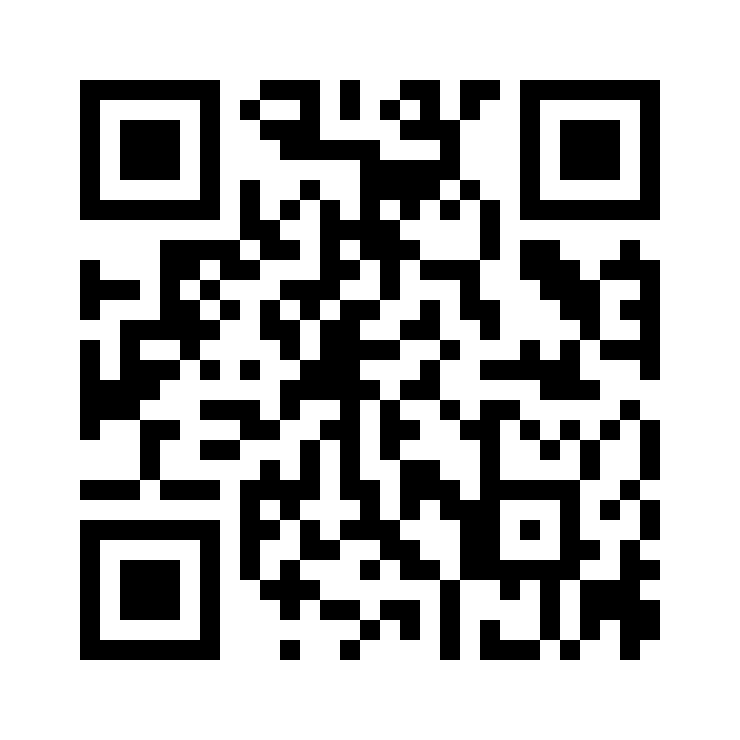

In [9]:
# Generate a QR Code image from a text prompt
import qrcode

qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_H,
    box_size=20,
    border=4
)
qr.add_data('http://simonguest.com')
qr.make(fit=True)

img = qr.make_image(fill_color="black", back_color="white")
img

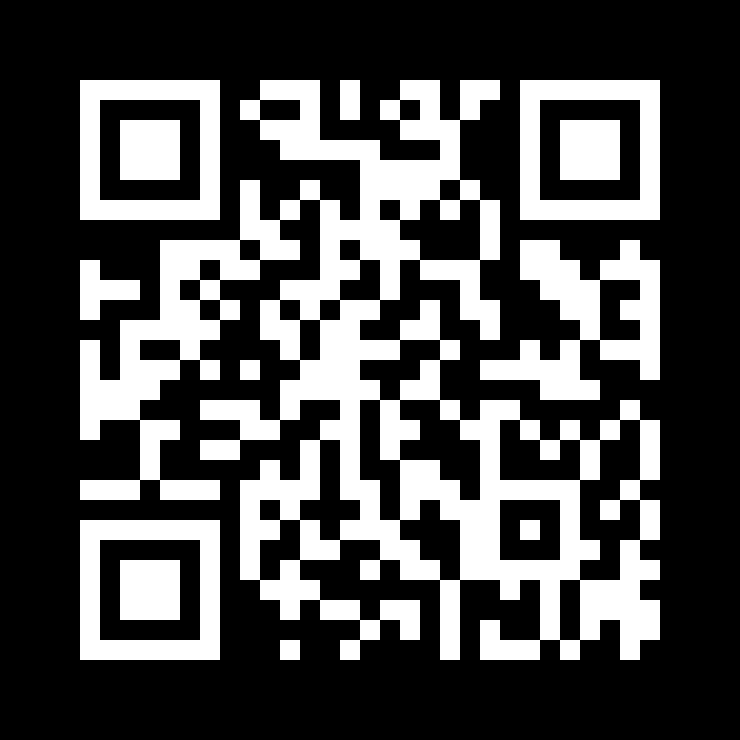

In [5]:
import cv2
import numpy as np
from PIL import Image

from diffusers.utils import load_image

image = load_image("./images/qrcode.png")

image = np.array(image)
image = cv2.bitwise_not(image)
image = Image.fromarray(image)

image

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

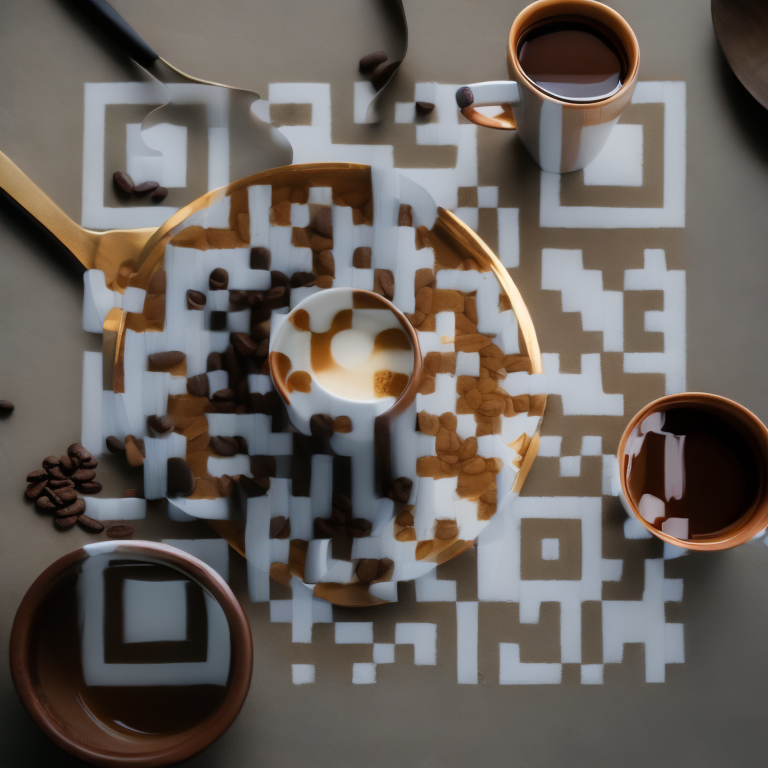

In [27]:
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v11p_sd21", )

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    controlnet=controlnet,
)

pipe.to("mps")

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

# play with guidance_scale, controlnet_conditioning_scale and strength to make a valid QR Code Image

# qr code image
source_image = load_image("./images/qrcode.png")
# initial image, anything
init_image = load_image("./images/bio.png")
condition_image = resize_for_condition_image(source_image, 768)
init_image = resize_for_condition_image(init_image, 768)
generator = torch.manual_seed(123121231)
image = pipe(prompt="looking down on three cups of coffee and spilled coffee beans",
             negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
             image=init_image,
             control_image=condition_image,
             width=768,
             height=768,
             guidance_scale=5,
             controlnet_conditioning_scale=1.5,  # Raise this to make the QR Code more visible / accurate
             generator=generator,
             strength=0.9,
             num_inference_steps=150,
             )

image.images[0]